In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, activations
from tensorflow.keras.models import Sequential, Model
import matplotlib.pyplot as plt

import tensorflow_addons as tfa

/Users/marek/global/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/marek/global/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/Users/marek/global/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and s

In [2]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()


In [3]:
# Parameters
batch_size = 256
num_epochs = 100
image_size = 72  
patch_size = 6
num_patches = (image_size // patch_size) ** 2
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [4]:
AugmentData = Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name = 'AugmentData'
)
AugmentData.layers[0].adapt(x_train)

In [5]:
def MultiLayerPerceptron(x, hidden_layers, dropout_rate):
    for units in hidden_layers:
        x = layers.Dense(units=units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)

    return x

In [6]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size
    
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patch_dimensions = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dimensions])
        return patches

(-0.5, 31.5, 31.5, -0.5)

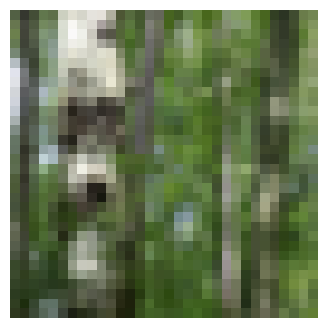

In [7]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


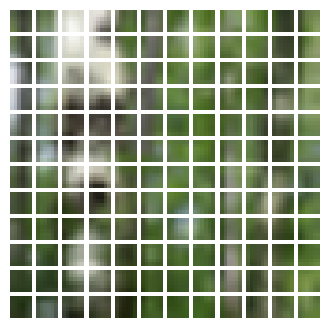

In [8]:
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [9]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [10]:
def VisualTransformerClassifier(transformer_layers, projection_dim, num_heads):
    transformer_units = [
        projection_dim * 2,
        projection_dim,
    ]
    
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = AugmentData(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = MultiLayerPerceptron(x3, hidden_layers=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = MultiLayerPerceptron(representation, hidden_layers=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=logits)
    return model

In [11]:
def train_evaluate_model(model, num_epochs, learning_rate, weight_decay):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )
    
    model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1
    )

    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    
    return accuracy

In [12]:
def objective_function(trial):
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    transformer_layers = trial.suggest_int('transformer_layers', 6, 10)
    projection_dim = trial.suggest_int('projection_dim', 32, 256, step=32)
    num_heads = trial.suggest_int('num_heads', 2, 8, step=2)
    num_epochs = trial.suggest_int('num_epochs', 64, 512, step=64)
    
    model = VisualTransformerClassifier(
        transformer_layers=transformer_layers,
        projection_dim=projection_dim,
        num_heads=num_heads
    )
    
    accuracy = train_evaluate_model(
        model=model,
        num_epochs=num_epochs,
        learning_rate=learning_rate,
        weight_decay=weight_decay
    )

    return accuracy
    

In [13]:
import optuna

study = optuna.create_study(direction='maximize')  # maximize accuracy

study.optimize(objective_function, n_trials=50)

best_params = study.best_params

/Users/marek/global/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2023-11-18 16:06:22,917] A new study created in memory with name: no-name-26c0f964-bcbd-442c-ae5a-6f308892015a


Epoch 1/64
  3/176 [..............................] - ETA: 7:57 - loss: 7.2346 - accuracy: 0.0117 - top-5-accuracy: 0.0664    

[W 2023-11-18 16:06:37,631] Trial 0 failed with parameters: {'learning_rate': 0.00026761057903235336, 'weight_decay': 1.5571053921251207e-06, 'transformer_layers': 8, 'projection_dim': 96, 'num_heads': 2, 'num_epochs': 64} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/marek/global/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/9w/xll0nt3d2sv6trb6s8yp6qwr0000gn/T/ipykernel_4520/3502618551.py", line 15, in objective_function
    accuracy = train_evaluate_model(
  File "/var/folders/9w/xll0nt3d2sv6trb6s8yp6qwr0000gn/T/ipykernel_4520/852315199.py", line 15, in train_evaluate_model
    model.fit(
  File "/Users/marek/global/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/Users/marek/global/lib/python3.9/site-packages/keras/src/engine/training.py", line 1807, in fit
 

KeyboardInterrupt: 

In [ ]:
def final_train(model, num_epochs, learning_rate, weight_decay):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [ ]:
final_model = VisualTransformerClassifier(
    transformer_layers=best_params['transformer_layers'],
    projection_dim=best_params['projection_dim'],
    num_heads=best_params['num_heads']
)

final_history = final_train(
    model=final_model,
    num_epochs=best_params['num_epochs'],
    learning_rate=best_params['learning_rate'],
    weight_decay=best_params['weight_decay']
)